In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

In [2]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [35]:
# context initialization
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=cnn_transformer_paragraphs"])

seed: 4711
tune: false
train: true
test: true
logging: INFO
work_dir: ${hydra:runtime.cwd}
debug: false
print_config: false
ignore_warnings: true
summary:
- - 1
  - 1
  - 576
  - 640
- - 1
  - 682
callbacks:
  lightning:
    model_checkpoint:
      _target_: pytorch_lightning.callbacks.ModelCheckpoint
      monitor: val/loss
      save_top_k: 1
      save_last: true
      mode: min
      verbose: false
      dirpath: checkpoints/
      filename: '{epoch:02d}'
    learning_rate_monitor:
      _target_: pytorch_lightning.callbacks.LearningRateMonitor
      logging_interval: step
      log_momentum: false
  wandb:
    watch_model:
      _target_: callbacks.wandb_callbacks.WatchModel
      log: all
      log_freq: 100
    upload_code_as_artifact:
      _target_: callbacks.wandb_callbacks.UploadConfigAsArtifact
    upload_ckpts_as_artifact:
      _target_: callbacks.wandb_callbacks.UploadCheckpointsAsArtifact
      ckpt_dir: checkpoints/
      upload_best_only: true
    log_text_predictions

In [36]:
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

2021-10-11 22:01:56.908 | INFO     | text_recognizer.data.iam_paragraphs:setup:92 - Loading IAM paragraph regions and lines for None...
2021-10-11 22:02:16.771 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/paragraphs.yaml
2021-10-11 22:02:19.953 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: test_transform/paragraphs.yaml
2021-10-11 22:02:19.957 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:67 - IAM Synthetic dataset steup for stage None...
2021-10-11 22:02:32.207 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/paragraphs.yaml


IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19882, 262, 231
Train Batch x stats: (torch.Size([4, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0316), tensor(0.0974), tensor(1.))
Train Batch y stats: (torch.Size([4, 682]), torch.int64, tensor(1), tensor(57))
Test Batch x stats: (torch.Size([4, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0321), tensor(0.0744), tensor(0.8118))
Test Batch y stats: (torch.Size([4, 682]), torch.int64, tensor(1), tensor(57))



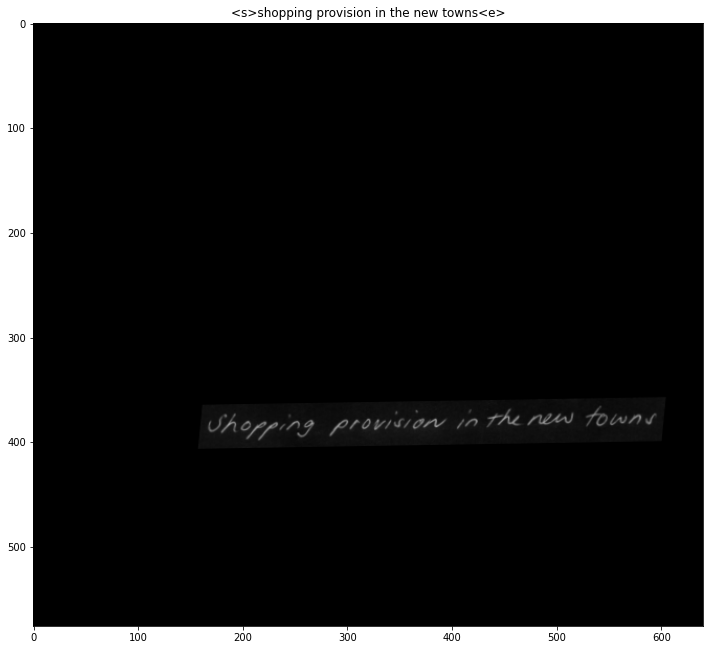

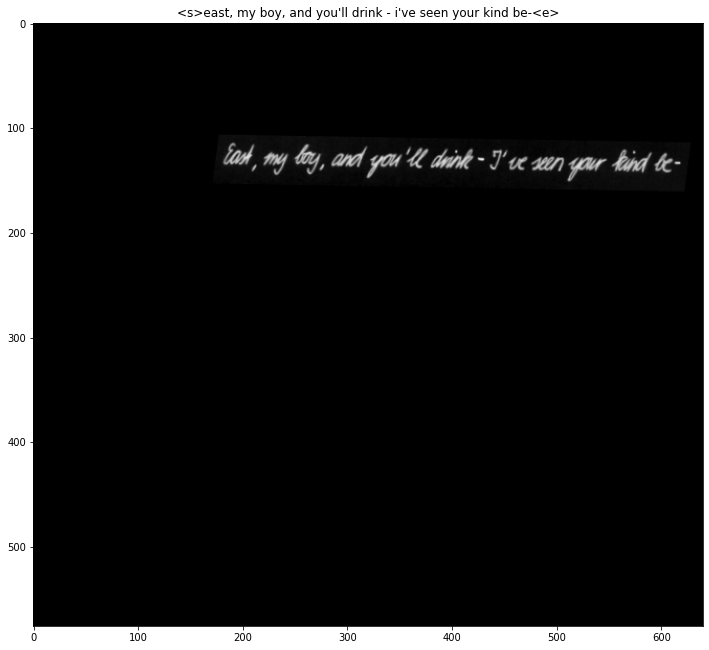

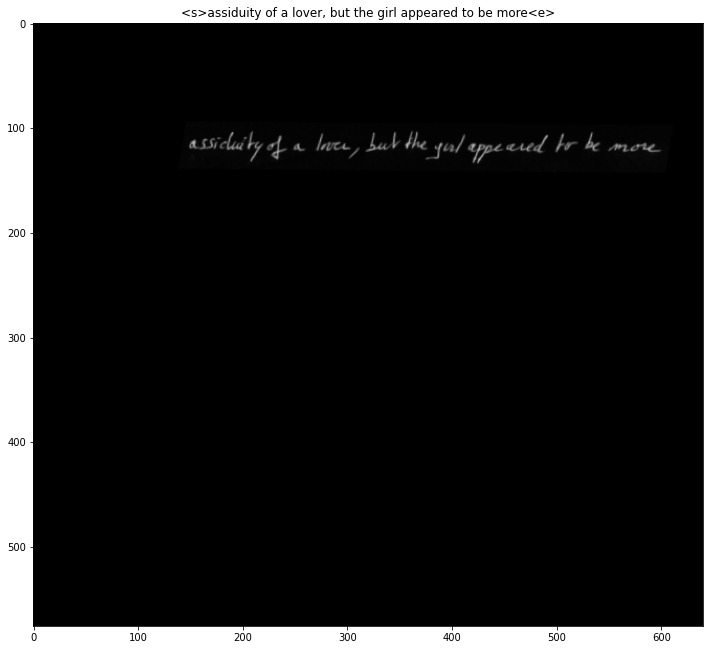

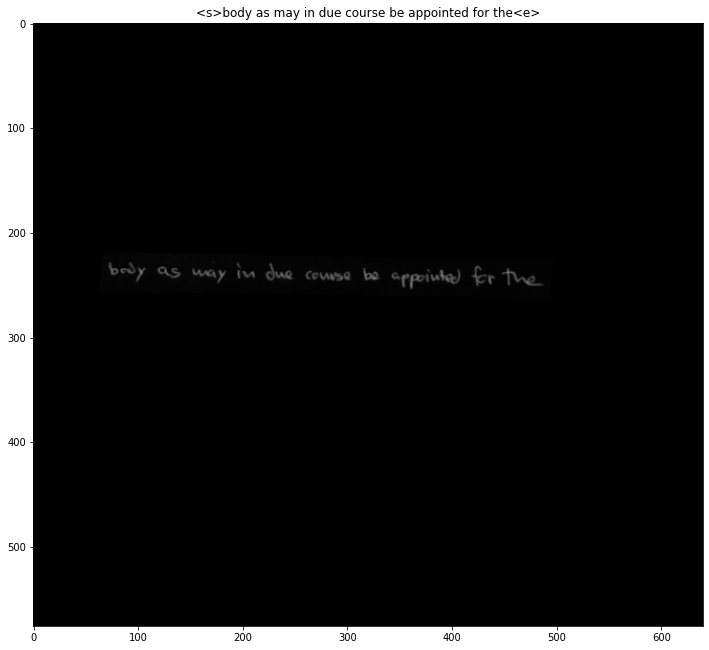

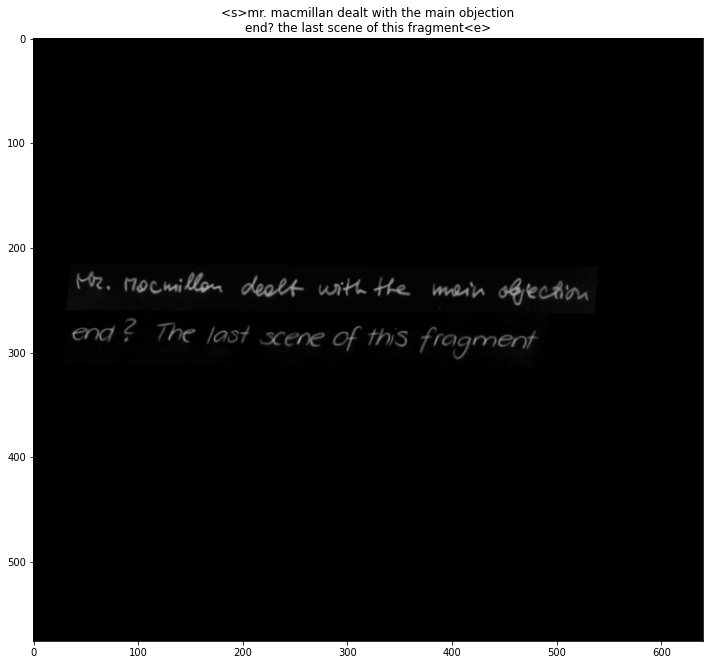

In [16]:
# Training
dataset = datamodule.data_train
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

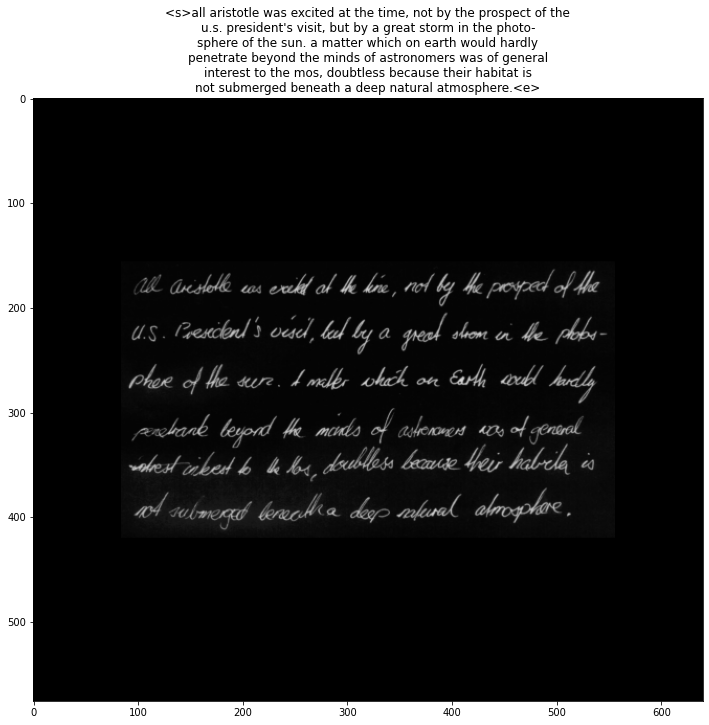

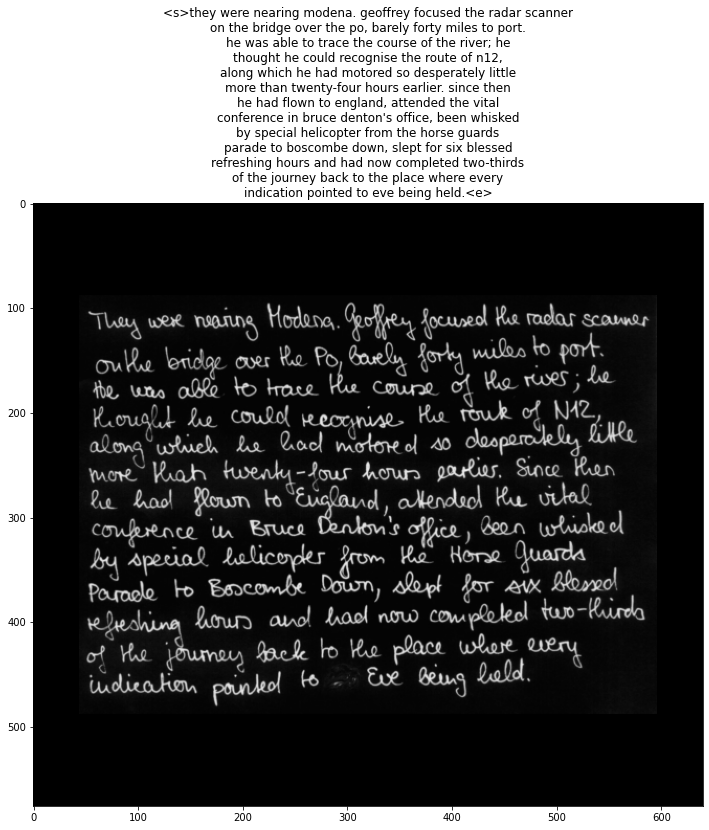

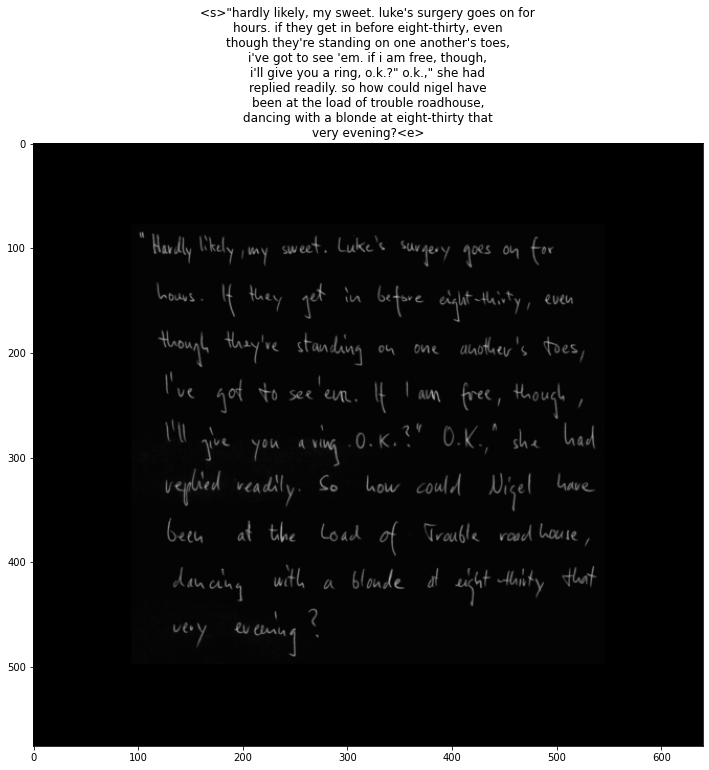

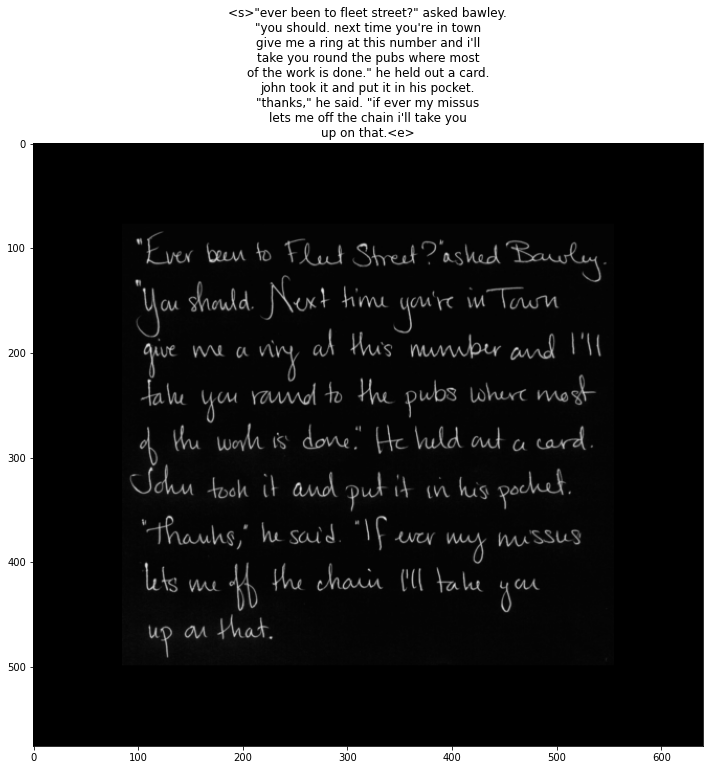

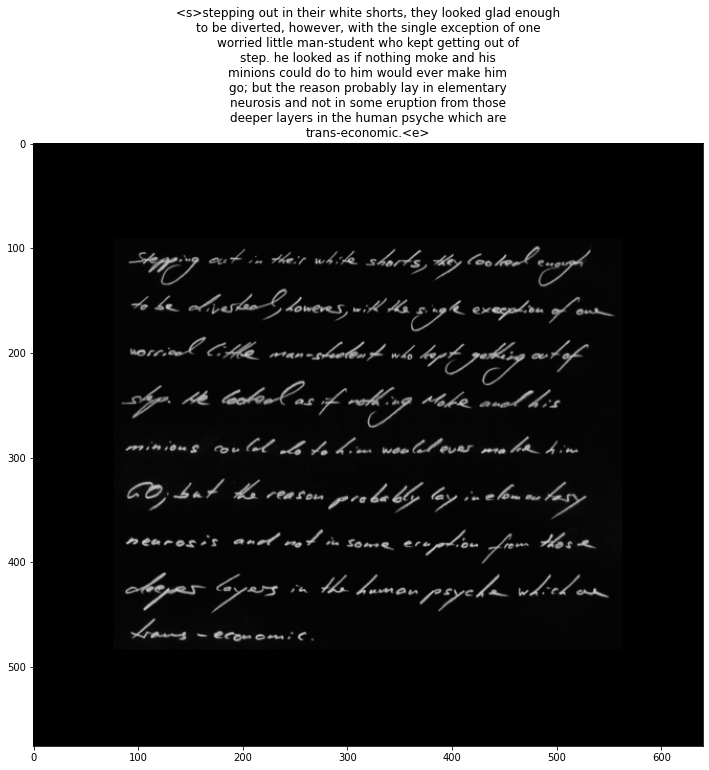

In [18]:
# Testing
dataset = datamodule.data_test
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))